# Tumblr Post Network Analysis
_Replicating the Tumblr Labs Reblog Graphs and discussion of Tumblr as a social science data source_

By Q Chen and Stephanie Ye-Mowe

## Table of Contents
1. Introduction and Project Goals
2. Methodology
3. Results
4. Discussion and Limitations
5. Conclusion

## Introduction and Project Goals
Tumblr is a social media platform that allows users to create blogs, post text, images, videos, and much more, and reblog and like other people’s posts. Through reblogging, a chain of relationships and different communities can be identified, as all posts have a source. Tumblr Labs, a development team of the platform, created a network graphs visual tool that users can enable and see in their dashboard feed (Figure 1). This tool generates a network graph for each post in the feed, and identifies the source blog as well as the blogs that reblog the post. The tool also tells the user how many reblogs deep a node blog is at. 


<img src="Reblog%20Graphs%20Sample.PNG" alt="Reblog Graph Sample" style="width: 400px;"/>
<p style="text-align: center;">_Figure 1_. Tumblr Labs Reblog Graphs showing a reblog.</p>

For this project, we are looking to replicate the network graphs generated by the Reblog Graphs, through the use of web scraping, network analysis, and matplotlib visualizations. We wanted to challenge ourselves in using the packages learned in class in an application towards our interests. We would also like to discuss the implications of Tumblr network analysis on social science research and Tumblr as a possible data source, through our project discoveries. 

We have two main goals:
1. Replicate the Reblog Graphs using Python packages BeautifulSoup, Pandas, NetworkX, and MatplotLib. 
2. Discuss our results in the context of Tumblr as a possible data source for network analysis and social science research.


## Methodology
Our methods will use several Python packages, as imported in the cell below. To set up, we have determined a Tumblr post of interest on its source blog, and saved that URL to a variable. 


In [1]:
## Import python packages

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.request import urlopen
from bs4 import BeautifulSoup
import string
import re
import networkx as nx

url = "http://eurosong.tumblr.com/post/160511885918/good-afternoon-folks-and-welcome-to-todays"

### Web Scraping
	
To generate a network visualization of a post, we first need to collect data on the users who reblogged and liked the post. Tumblr is designed such that each time a post is posted or reblogged it is given it’s own subpage on the blog of the individual who posted or reblogged it. When one accesses one of these subpages, they will see the post’s notes, all the reblogs and likes that a post receives. Thus, we can use the Python package BeautifulSoup and the webpage’s HTML to scrape and organize these reblogs and likes.

Post webpages initially only display 50 notes. To access more notes, an individual may click “See More Notes”, a feature that exists on most, but not all, blogs. This feature takes 50 notes stored on another subpage and updates the post webpage with this information. While visible on page, this updated information does not appear in the source code. Thus, we need to access the subpage that this feature extracted this information from to collect these additional notes. The subpage itself is limited 50 initial notes, and accesses additional notes in the same way as the original page. To extract all the notes, we need to continuously access these additional notes until we reach an endpoint (when the “See More Notes” feature tries to access a blank page). Unfortunately, Tumblr does not make all notes accessible. The number of notes accessible vary per blog, and per post. 

Within each webpage, the each note is held in a different “li” tag. By invoking `findAll(“li”)`, we can thus generate a list of notes. From here, we separate the notes based on type. To determine whether a note is a like, reblog, or reblog with a comment, we can look at the number of items held within “a” tags for each note. Then we can use `get_text()`, blank, attrs, to get the additional information. These can then we loaded onto a dataframe. While we create different dataframes for the reblogs and likes, we then merge them. 


In [2]:
# Assigns variable "urlhandle" to url of post's source blog (obtained from post url using regex)
# Post's url is accessed, and the content turned into a BeautifulSoup object 
# From here, all content held within "ol" (ordered list) tags is located and added to the list 'sections2' 
# (There should only be one item this list)
# Next, all content found within "li" (list item) tags from the 'ordered list' string is added to the list "sections"
# Each element in "sections" is a 'note' (a like/reblog of the post)

urlhandle = (re.findall('http[s]*://[A-Za-z0-9-]+\.tumblr\.com/', url))[0] 

html = urlopen(url)
content = BeautifulSoup(html,"html5lib")                               
sections2 = content.findAll("ol")
sections=sections2[0].findAll("li")

#### Scrapping all the Notes

When a user opens a post's webpage, they will not be able to see all the post's notes right away. They will only see 50.

While not available on every blog, most blogs will, however, have a feature that allows you to see beyond these inital 50 notes. By clicking "See More Notes", the page will update with 50 more notes that it extracted from another webpage. By clicking this option repeatedly, you will get increasingly more notes until you reach a maximum. This maximum, appears to vary by both post and by blog.

While the additional notes are visible on the user end, the information will not update in the source code. To scrape these additional notes, one has to access the other webpage the original page extracted information from.


Each element in sections, has a certain number of items held in "a" tags based on what type of note it codes for:

    # 1 = Not actually a note, but an option to "Show More Notes"
    # 2 = A like or a line stating "Username posted this" (this only appears once and only as the last note)
    # 3 = A reblog with no comment
    # 4 = A reblog with a comment 


In [3]:
x= sections[-1].findAll("a") # Creates a list of all elements held in "a" tags for the last note

# It is important to note that is the length of list "x" is 1, 
#     then it was not a note but rather an option to "Show More Notes"
# By continuously checking for this and adding the notes on the webpage 
#   it leads to to our list, we can extract the maxmimum number of notes

while len(x)==1: 
    y=str(x[0])
    y= (re.findall('notes/[0-9]+/[A-Za-z0-9]+\?from_c=[0-9]+', y))[0] 
    # Uses regex to find the url to the webpage that contains the additional notes
    
    nextpage= urlhandle+y
    
    html=urlopen(nextpage)
    content=BeautifulSoup(html,"html5lib")
    sectionsnext=content.findAll("li")
    
    if len(sectionsnext)>0: # Occasionally, a page will include a "Show More Notes" option when none are available. 
                            # By making sure we actually extracted content from the new page (if len(sectionsnext) > 0)
                            # We make sure we don't create an error trying to call elements that don't exist
                
        x=sectionsnext[-1].findAll("a")
        
        for i in range(len(sectionsnext)): # All notes from the new list are added to the original list
            sections.append(sectionsnext[i]) 
            # And the cycle repeats until the last note in our list finally has 2 elements in contained in "a" tags
            # Meaning (since its the very last item) it is the "Username posted this" line
            
    else:
        x=[]
    
    continue 

#### Reblogs

In [4]:
reblogs=[]

# Creates a list of where is element is a list containing the...
# source username, source url, recipient username, recipient url, and comment content (if any) of a single reblog

for i in range(len(sections)):
    x=sections[i].findAll("a") 
    # Checks each element in list "sections" if it has > 2 items in "a" tags (which means its a reblog)
    if len(x)>2:
        row=[]
        
        user=x[1].get_text() 
        #By removing all the html formatting code of the 2nd item held in "a" tags, you get the recipient username
        link=x[1].attrs['href'] 
        #By looking for content with the attribute 'href' in the 2nd item held in "a" tags, you get the recipient url
        
        
        # Same as above, but you work with the 3rd item and get the source username and source url
        user2=x[2].get_text() 
        link2=x[2].attrs['href']
        
        row.append(user) 
        # The recipient and source information is then added to the list 'row' 
        #     (which will make up one row in the dataframe)
        row.append(link)
        row.append(user2)
        row.append(link2)
        
        if len(x)>3: # If there are > 3 items in "a" tags, we know a comment was added during the reblog
            comment = x[3].get_text() 
            # This allows us to extract the comment, clean it, and append it as the 5th item in "row"
            comment= re.sub('\n+', " ", comment) #Removes excess new line characters                           
            comment = re.sub(' +', " ", comment) #Removes excess spaces   
            row.append(comment)
            
        else:
            row.append("") # If no comment was added, the string "None" is simply added as the 5th item
        
        reblogs.append(row)
        
    else:
        continue

In [5]:
reblogs

[['iriaowillwinesc',
  'https://iriaowillwinesc.tumblr.com/',
  'arabela25',
  'http://arabela25.tumblr.com/',
  ''],
 ['xiithdoctor',
  'http://xiithdoctor.tumblr.com/',
  'mapsontheweb',
  'https://mapsontheweb.zoom-maps.com/',
  ''],
 ['adventurenerd',
  'http://adventurenerd.tumblr.com/',
  'clickthing',
  'http://clickthing.tumblr.com/',
  ''],
 ['slenderboobs',
  'http://slenderboobs.tumblr.com/',
  'mapsontheweb',
  'https://mapsontheweb.zoom-maps.com/',
  ''],
 ['wherethefuckdidthisshitcomefrom',
  'https://wherethefuckdidthisshitcomefrom.tumblr.com/',
  'mapsontheweb',
  'https://mapsontheweb.zoom-maps.com/',
  ''],
 ['magrittesflamingtuba',
  'http://magrittesflamingtuba.tumblr.com/',
  'mapsontheweb',
  'https://mapsontheweb.zoom-maps.com/',
  ''],
 ['thatdysfunctionalkingdom',
  'https://thatdysfunctionalkingdom.tumblr.com/',
  'mapsontheweb',
  'https://mapsontheweb.zoom-maps.com/',
  ''],
 ['monterrang-parkin',
  'https://monterrang-parkin.tumblr.com/',
  'mapsontheweb',


In [6]:
len(reblogs)

38

#### Non-Reblog Comments

In [7]:
comments=[]
indexs=[]

for i in range(len(sections)):
    x=sections[i].get_text()
    text=x.split(" ")
    
    if text[1]=="said:":
        row=[]
        
        user=text[0]
        del text[:2]
        text=" ".join(text)
        text= re.sub('\n+', " ", text) #Removes excess new line characters                           
        text = re.sub(' +', " ", text) #Removes excess spaces   
    
        row.append(user)
        
        t=sections[i].findAll("a")
        url=t[1].attrs['href']
        row.append(url)
        
        row.append(text)
        
        comments.append(row)
        indexs.append(i)
        
for i in range(len(indexs)):
    del sections[indexs[i]]

In [8]:
comments

[]

In [9]:
len(comments)

0

#### Likes

In [10]:
likes=[]

for i in range(len(sections)): # For each note in sections, use findAll() to locate all content held within "a" tags
    x=sections[i].findAll("a") # If each note had two strings held within "a" tags, it is a like. 
    if len(x) ==2: 
        row=[]                      
        
        user=x[1].get_text() 
        # Removes html formatting code from the 2nd item held in "a" tags 
        #     to get the username of the individual liking the post
        link=x[1].attrs['href'] 
        # Looks for an item with the attribute "href" from the 2nd item held in "a" tags to get the user's blog url
        
        row.append(user) # Adds the username and url to a list named 'row' 
        row.append(link)
        
        likes.append(row) # The list 'row' is appended to the list 'likes'
        
    else:
        continue

In [11]:
len(likes)

98

#### Original Poster (OP)

In [12]:
originalposter=likes[-1]
# The last element in the 'likes' list is not a like, but rather the name of the blog who published the post
originalposter[0]

'eurosong'

As seen in the cell above, there is at least one note of the post dedicated to show who created the post. While this is also how we retrieve our OP's name, that particular kind of note does not reflect the 'likes' list, and so all occurrences of the OP in the 'likes' list must be removed. This is because sometimes there is more than one note saying "OP created this post", resulting in duplicate OPs.

In [13]:
# deletes all instances of OP in likes list
#     which will prevent node and edge lookup problems regarding eurosong
for i,blog in enumerate(likes):
    if blog[0] == originalposter[0]:
        del likes[i-1]
len(likes)

95

#### Creating the Network Dataframe (edgelist)

In [14]:
for i in range(len(reblogs)): 
    # Each element in the 'reblogs' list is a list containing all information for one reblog 
    reblogs[i].append(1)
    # Appending "1' to each reblog's list allows us to signify the existence of a 
    #     reblog relationship between the source and recipient user   
    x=0
        
    for t in range(len(likes)): # For each like in the 'likes' list
    
        if reblogs[i][1]== likes[t][1]: 
            # We check if the Tumblr user of the like matches with any of the recipient users in the reblog list
            x=1                         # If yes, the x is set to "1" (The default was 0)
            del likes[t]                # And the like is deleted from the likes list 
            break                       # Once a match is found, loop breaks and the search ends 
            
        else:
            continue 
            
    
    reblogs[i].append(x)
    # The "x" (which is either a 1 or 0 to signify the existence/non-existence of a like relationship) 
    #     is appended to the reblog

In [15]:
for i in range(len(likes)): 
    # For the Tumblr Users who didn't also reblog, 
    #    we add additional information so they can be merged with the 'reblog' list
   
    likes[i].append(originalposter[0])
    likes[i].append(originalposter[1])
    likes[i].append("") # Indicates that there were no comments (You cannot add a comment when you like on Tumblr)
    likes[i].append(0) # Indicates non-existence of a reblog relationship
    likes[i].append(1) # Indicates existence of a like relationship
    
    reblogs.append(likes[i])

In [16]:
df_network=pd.DataFrame(reblogs)
df_network.columns = ["target", "Recipent URL", "source", "Source URL", "comment", "reblog", "like"]
df_network

,target,Recipent URL,source,Source URL,comment,reblog,like
0,iriaowillwinesc,https://iriaowillwinesc.tumblr.com/,arabela25,http://arabela25.tumblr.com/,,1,0
1,xiithdoctor,http://xiithdoctor.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,0
2,adventurenerd,http://adventurenerd.tumblr.com/,clickthing,http://clickthing.tumblr.com/,,1,0
3,slenderboobs,http://slenderboobs.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,1
4,wherethefuckdidthisshitcomefrom,https://wherethefuckdidthisshitcomefrom.tumblr...,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,0
5,magrittesflamingtuba,http://magrittesflamingtuba.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,0
6,thatdysfunctionalkingdom,https://thatdysfunctionalkingdom.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,0
7,monterrang-parkin,https://monterrang-parkin.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,@ph0220,1,1
8,wymanthewalrus,http://wymanthewalrus.tumblr.com/,mapsontheweb,https://mapsontheweb.zoom-maps.com/,,1,1
9,alwaysfriedstudent-b07d5fd2,https://alwaysfriedstudent-b07d5fd2.tumblr.com/,eurosong,http://eurosong.tumblr.com/,,1,1


In [17]:
columns = ["Recipent URL", "Source URL"]
df_network.drop(columns, inplace=True, axis=1)
df_networkshort = df_network.reindex_axis(['comment',"reblog", "like", "target", "source"], axis=1)

In [18]:
# Displaying the entire dataframe, without hiding rows
with pd.option_context('display.max_rows', None, 'display.max_columns', 5):
    display(df_networkshort)

,comment,reblog,like,target,source
0,,1,0,iriaowillwinesc,arabela25
1,,1,0,xiithdoctor,mapsontheweb
2,,1,0,adventurenerd,clickthing
3,,1,1,slenderboobs,mapsontheweb
4,,1,0,wherethefuckdidthisshitcomefrom,mapsontheweb
5,,1,0,magrittesflamingtuba,mapsontheweb
6,,1,0,thatdysfunctionalkingdom,mapsontheweb
7,@ph0220,1,1,monterrang-parkin,mapsontheweb
8,,1,1,wymanthewalrus,mapsontheweb
9,,1,1,alwaysfriedstudent-b07d5fd2,eurosong


### Network Analysis

With the Pandas dataframe edgelist of our scraped data clean and complete, we now move onto the network analysis of our data. Due to the experimental aspect of our project, we will visualize our network with NetworkX (nx) and Matplotlib (plt). 

We convert our dataframe edgelist into a network graph using the nx function `from_dataframe_edgelist`. In this function, we identify the source node and target node columns to create the edge, as well as the edge attributes. 


In [19]:
## Create network graph
g = nx.from_pandas_edgelist(df_networkshort, 'source', 'target', ['like', 'reblog', 'comment'])

With our new network graph created, we can start the visualization process. We know that we will be showing the post’s original poster (OP) as a node as well as all the other blogs that have interacted with it, so we want to differentiate between the two blog types by giving the nodes different colours. The code below loops through the nodes of our graph and sorts them into two lists, identifying if they are the OP node or other nodes. 

In [20]:
## Create opnode and others nodelists
opnode = []
others = []

for node in g.nodes():
    if node == originalposter:
        opnode.append(node)
    else:
        others.append(node)

opnode

[]

We also want to visually differentiate the three relationship types of ‘liked’, ‘reblogged’, and ‘both’, which we can do by drawing the edges in different colours and styles, like dashed lines. The code below loops through the edges and sorts them into three lists, identifying if the interaction was both liking and reblogging, only liking, or only reblogging. 

In [21]:
## Create edgelists
bothlist = []
likelist = []
rebloglist = []


for (s,t,d) in g.edges(data=True):
    if d['like'] == 1 and d['reblog'] == 1:
        bothlist.append((s,t,d))
    elif d['like'] == 1:
        likelist.append((s,t,d))
    elif d['reblog'] == 1:
        rebloglist.append((s,t,d))
    else:
        print('no style')

print(bothlist)
print(likelist)
print(rebloglist)

[('mapsontheweb', 'slenderboobs', {'like': 1, 'reblog': 1, 'comment': ''}), ('mapsontheweb', 'monterrang-parkin', {'like': 1, 'reblog': 1, 'comment': ' @ph0220 '}), ('mapsontheweb', 'wymanthewalrus', {'like': 1, 'reblog': 1, 'comment': ''}), ('mapsontheweb', 'duksisdarker', {'like': 1, 'reblog': 1, 'comment': ''}), ('mapsontheweb', 'imarwood', {'like': 1, 'reblog': 1, 'comment': ''}), ('mapsontheweb', 'heirofavians', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'alwaysfriedstudent-b07d5fd2', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'mmarieto', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'portugalpirate', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'theportugueserevert', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'literallynotcoolirl', {'like': 1, 'reblog': 1, 'comment': ''}), ('eurosong', 'deathatintervals', {'like': 1, 'reblog': 1, 'comment': ''})]
[('eurosong', 'notacolorfullesbian', {'like': 1, 'reblog': 0, 'comment': ''}), (

We then begin to piece together the visualization process, starting with defining our network layout, which is the spring layout. We also define the size of our plt figure, which is large, in case our network is very crowded. 

We then draw the actual nodes and edges of the graph. We call the same node-drawing function two times in order to give the nodes two different styles, and call the same edge-drawing function three times to give the edges three different styles. 

We want the OP’s node to be red to make it quickly identifiable. All other blog nodes will be green. For edges, a ‘like’ relationship will be a dashed orange line, a ‘reblog’ will be a solid green line, and a relationship of both ‘like’ and ‘reblog’ will be a solid red line. These colours and styles will make the ‘both’ and ‘reblog’ relationships stand out more. 

Finally, we will label the nodes of the network with the blog usernames, and show the figure!

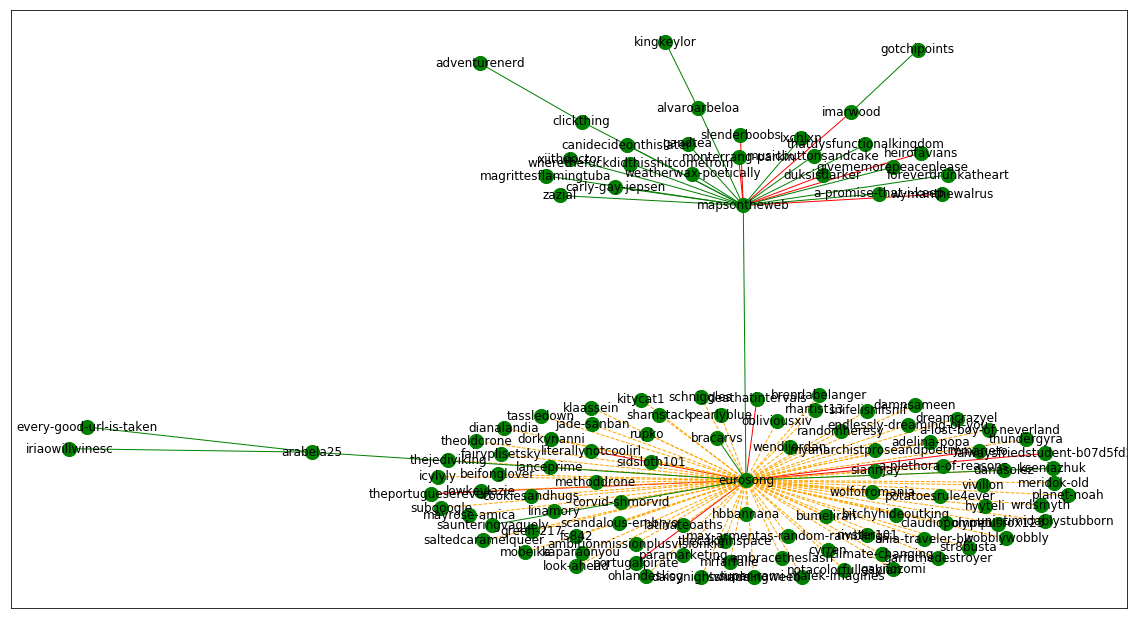

In [22]:
## define network layout
pos = nx.spring_layout(g)

## define figure size
plt.figure(figsize=(20,11))

## draw nodes
nx.draw_networkx_nodes(g, pos, nodelist = opnode, node_color = 'r', node_size = 500)
nx.draw_networkx_nodes(g, pos, nodelist = others, node_color = 'green', node_size = 200)

## draw edges by group
nx.draw_networkx_edges(g, pos, edgelist = bothlist, edge_color = 'r', style = 'solid', arrows = False)
nx.draw_networkx_edges(g, pos, edgelist = likelist, edge_color = 'orange', style = 'dashed', arrows = False)
nx.draw_networkx_edges(g, pos, edgelist = rebloglist, edge_color = 'g', style = 'solid', arrows = False)

## draw node labels
nx.draw_networkx_labels(g, pos)

## show drawing
plt.xticks([])
plt.yticks([])
plt.show()

Given the name of the source blog and another blog of interest, we can also calculate how many reblogs deep the other blog is in the reblog relationship chain from the source blog, which is one of the metrics the Tumblr Labs tool gives upon the user clicking a blog. The code below uses the nx function `all_simple_paths` which, given the graph, source node, and target node, generate a list of all simple paths from source to target node. Due to the nature of our data, it should be impossible for a target blog to be linked to the source blog by more than one path, so the length of the path minus one (for the source blog) should be how many reblogs deep the target blog is from the source blog. 


In [23]:
def reblogsdeep(s,t):
    for path in nx.all_simple_paths(g, source=s, target=t):  
        print('Path: ', path)
        
        if len(path) == 2:
            for (se,te,de) in g.edges(data=True):
                if se == path[0] and te == path[1] and de['reblog'] == 0:
                    print(t,"has a 'like'-only relationship.")
        else:
            print(t,'is',(len(path)-1),'reblogs deep.')

In [24]:
s = originalposter[0]
t = 'kingkeylor'

reblogsdeep(s,t)

Path:  ['eurosong', 'mapsontheweb', 'alvaroarbeloa', 'kingkeylor']
kingkeylor is 3 reblogs deep.


As we can see from the output above, the target blog ‘kingkeylor’ is 3 reblogs deep. It is important to note that with this method, blogs with a ‘like’ relationship and not a ‘reblog’ or ‘both’ relationship will also return a result; the result is perhaps more accurately described as the degrees of separation between the source and target blogs. Our function checks for this with an if statement that looks into the edge attributes if the path likely describes a ‘like’ relationship, which is when the target blog has a direct relationship with the original poster. An example of this is shown below. 

In [25]:
s = originalposter[0]
t = 'tassledown'

reblogsdeep(s,t)

Path:  ['eurosong', 'tassledown']
tassledown has a 'like'-only relationship.


## Results

For the example blog post that we have run the Methodology section on, the post has 146 notes. From those notes, we were able to scrape and produce a clean dataset of 121 relationships, where 95 likes and 38 reblogs are merged together. There is only one reblog with a comment. The full merged dataframe (Table 1) can be seen by running the cell below.

In [26]:
# Displaying the entire dataframe, without hiding rows
with pd.option_context('display.max_rows', None, 'display.max_columns', 5):
    display(df_networkshort)

,comment,reblog,like,target,source
0,,1,0,iriaowillwinesc,arabela25
1,,1,0,xiithdoctor,mapsontheweb
2,,1,0,adventurenerd,clickthing
3,,1,1,slenderboobs,mapsontheweb
4,,1,0,wherethefuckdidthisshitcomefrom,mapsontheweb
5,,1,0,magrittesflamingtuba,mapsontheweb
6,,1,0,thatdysfunctionalkingdom,mapsontheweb
7,@ph0220,1,1,monterrang-parkin,mapsontheweb
8,,1,1,wymanthewalrus,mapsontheweb
9,,1,1,alwaysfriedstudent-b07d5fd2,eurosong


<p style="text-align: center;">_Table 1_. Final dataframe of edges of the example eurosong post.</p>

As seen in the cells and generated graph below (Figure 2), the original poster has a degree of 93, and the blog ‘mapsontheweb’ is their most influential reblogger, with a degree of 23. The graph uses the spring layout, and the data visualization is akin to a dandelion puff. The original poster appears to have mostly ‘like’ relationships, while the influential reblogger appears to have mostly ‘reblog’ relationships. 

In [27]:
print(g.degree('eurosong'))
print(g.degree('mapsontheweb'))

93
23


<img src="Graph.PNG" alt="Graph" style="width: 1000px;"/>
<p style="text-align: center;">_Figure 2_. NX generated graph of the example eurosong post.</p>

We were also able to replicate the “reblogs deep” metric, given that the user inputs appropriate values into the `reblogsdeep` function. 

## Discussion and Limitations

We were able to replicate a static version of the Tumblr Labs Reblog Graphs using Python 3 in the Jupyter Notebook environment, using several libraries including BeautifulSoup to scrape the data from Tumblr, Pandas for data management, and NetworkX to create the graph element, and Matplotlib to visualize the graph. While our graph is non-interactive, it is colour-coded to show the original poster and the blogs with different types of relationships with the OP post. We also created a method to show how many reblogs deep a blog was to the OP, which was part of the Reblog Graphs tool. 

One of our major research interests was to explore the viability of Tumblr as a data source for future network analysis and social science research. Within this exploration, we determined a few areas of discussion: quality of data from scraping, data available from API access, and usefulness of the type of social data that Tumblr creates in comparison to Twitter and Facebook, which are two major social media platforms that are already known and used in network analysis and social science research. 


### Quality of Data from Scraping

As seen in the Methodology and the Results sections, we had to do some cleaning to produce our final dataframe. The data that we collected was derived from the blog post’s notes, which generally follow the formats of “_user2_ reblogged this from _user1_” and “_user2_ liked this”. However, there were a few exceptions as noted in our web scraping, where some reblogs had comments, and some comments were somehow made separately from reblogs. Additionally, there was the problem of the ultimate “_user0_ posted this” to indicate the original poster, which our code treats as a ‘like’ relationship between the OP and themselves, which is untrue. The note that indicates the OP making the post also has been seen to repeat through the notes, as with our example post, which we also had to remedy. 

Tumblr blogs also do not always show all the notes of a post, especially when the post reaches over 200 notes, we have found. Under 200 notes, we are usually able to scrape all the notes, at least enough to generate a complete, single-component graph. However, at over 200 notes, we are unable to guarantee a complete scrape of all the notes as indicated on the post’s page; we have found that we are usually limited to 50 or 150 notes as our scraping result. Over the course of the project, we have been unable to find a solution for this limitation. 

Another limitation to the data we collect is that all ‘like’ relationships that do not have an associated ‘reblog’ relationship point directly to the OP, creating a short, single-edge path. While this relationship may be true in some cases, we know that there are also cases where someone views the post from someone else’s reblog and clicks like, and we are unable to access information that would tell us which version of the post they liked, if that information exists (it may not). 

Finally, there is also a limitation of Tumblr’s no-scraping policy that we acknowledge. The policy, found in Tumblr’s [Terms of Service](https://www.tumblr.com/policy/en/terms-of-service), says that:

    “You may not, without express prior written permission, do any of the following while accessing or using the Services: … scrape the Services, and particularly scrape Content (as defined below) from the Services; ...”.

We ended up scraping to collect the notes of the posts instead of using the Tumblr API, which is discussed later. Unfortunately, we had found the no-scraping policy fairly late into our project, so from here we can only suggest to acquire written permission from Tumblr before doing more scraping beyond the very small scale of our research. The main concern of Tumblr in regards to scraping is that the automated scraping could “interfere with or create an undue burden on the Services”, which could interfere or disrupt the access of registered Tumblr users. 


### Data Available from API Access

As mentioned before, we had decided to scrape the post’s notes instead of accessing data from the Tumblr API. This was because of the limitations of our project, which we wanted to do entirely in Python 3 while the API is available in JavaScript, and there were several unsolved issues with the Github-sourced Python package for accessing the Tumblr API, among them authentication. In the context of another project not limited by the choice of programming language, however, the Tumblr API would be a different direction to take this project in. 

The Tumblr API would have allowed for us to opportunity to access the information of a blog, its followers, and who they are following. While this needs the permission of several blogs to be useful, it would be easy to build up a network of blogs based on who is following who. With the Tumblr API, we can also search for posts by tags and retrieve the tags of a post, allowing us to create a network of blogs that post or reblog posts with tags of our interest. In regards to a post’s notes, which was our focus for this project, the Tumblr API allows the access of the 50 most recent notes of a given post, which does not provide enough data for the analysis that we did in this project, which is part of the reason we scraped for our data. 

There is different data available through the Tumblr API compared to our web scraping method, but overall web scraping is more flexible and customizable for data collection and social science research. 


### Usefulness of Data in Social Science Research

We wanted to discuss the usefulness of the type of social data that Tumblr creates, partly in comparison to data from Twitter and Facebook. Twitter and Facebook are popular sources of social network data because of their nature, where Twitter allows for social networking through public conversation, and Facebook allows for social networking through connecting friends and friends of friends. These two major social media platforms generate social networks transparently in many cases, where users can see who is following who on Twitter, and (depending on privacy settings and API authentication) who is friends with who on Facebook. 

In comparison, Tumblr as a social media platform limits social network analysis by not showing such information. In most cases, it is near impossible to retrieve the follower and following information of a blog without the blog’s permission to access it through the Tumblr API. The only information that is publicly available are the posts that the user publishes, their tags, and the posts’ notes. While some of this information can be used to derive a social network for analysis, the data to draw connections between blogs is limited compared to Twitter and Facebook. 

Additionally, the communities and subject material that exist in Tumblr are not as broad as those of Twitter and Facebook, the latter two being social networking services that more readily represent real life relationships in a digital form. While Tumblr allows people to make connections with others, these connections are usually made through a user’s blog name or alias, and communications are more about reaching a community audience instead of directly speaking to individuals. The main method of communication on Tumblr is blogging and sharing posts accessible by anyone, which is much broader that Twitter’s microblogging and Facebook’s enclosed, friend-based communications. Tumblr is much more focused on creating communities based on mutual interests such as fandoms, and less about the individual’s personal relationships. 

Overall, we find that the data Tumblr has limits its usefulness in the context of network analysis and social science research. Without a high quality and quantity of accessible data to draw strong connections between people, it is difficult to identify communities and interactions within and outside of those communities. Tumblr data may not be useful for many applications of research in social science, but there may be a few niche areas that Tumblr data can help address. 

## Conclusion

By learning how to scrape the web, store data in dataframes, and generate a network graph, we have been able to replicate most of the information provided by the Tumblr Labs Reblog Graph tool, with some limitations. With BeautifulSoup, we have been able to scrape the notes of Tumblr posts to grab the data on reblogs and likes, and also been able to associate that data with blogs, which became our nodes. With NetworkX and Matplotlib, we have been able to create network graphs and visualize them within Jupyter Notebook, and also create a static visual of the reblog relationships, much like the graphs that the Reblog Graph tool creates. Our visualizations take it one step further by showing if a blog’s relationship with the original poster is a reblog, like, or both. We have also been able to identify how many reblogs deep a blog is in the reblogging chain. 

Additionally, we have discussed the viability of Tumblr as a data source for future network analysis and social science research, paying special attention to the quality of data from scraping, the data available from API access, and the overall usefulness of Tumblr data for social science research. We determined that using web scraping, the quality of data was relatively good, but there was not a lot of data to work with due to the limitations of how many notes we could scrape. Some data was more accessible through the Tumblr API, but for this project the Python library for the Tumblr API has some unsolved problems beyond our understanding. The overall usefulness of Tumblr data was compared to Twitter and Facebook, and we found that while Tumblr could cover some niche research interests of network analysis and social science research, Tumblr’s system and the available data greatly limits its usefulness. 

## Contributions

### Stephanie
Stephanie coded most of the web scraping section, and also wrote most of the methodology for that part.

### Q
Q coded the network analysis section, and also wrote the methodology for that part. She also gave feedback and did debugging on some web scraping methods. Q also defined the final dataframe attributes and the expected data quality. For the rest of the report, she wrote the introduction, results, discussion, and conclusion. In her work, Q learned a lot about creating graphs with NetworkX and visualizing graphs, as well as the possibilities and limitations of static and dynamic/interactive visualizations in Jupyter Notebook. 